In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Base de dados - Usina de energia

AT - Temperatura ambiente

V -  Pressão de vapor

AP - Pressão atmosférica

RH - Umidade relativa

PE - Potência de saída

In [2]:
dados = pd.read_csv('usina.csv')
dados

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


<Axes: >

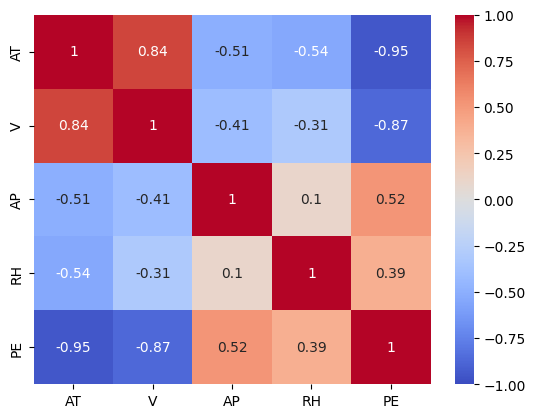

In [3]:
import seaborn as sns
corr = dados.corr()
sns.heatmap(corr, annot=True, center=0, vmin=-1, vmax=1, cmap='coolwarm')

# Relacionando as variáveis

In [4]:
import matplotlib.pyplot as plt
import plotly.express as px

Text(0, 0.5, 'Potencia de saida')

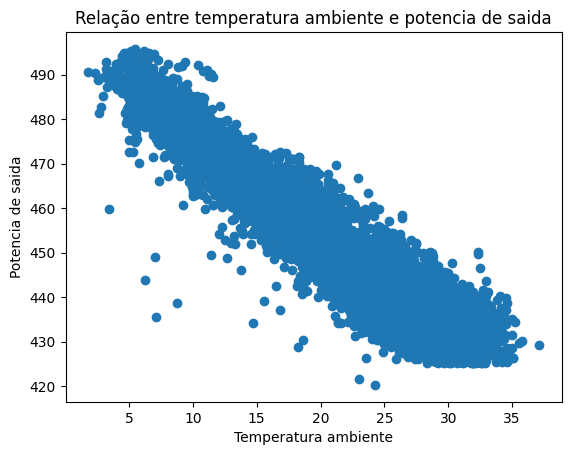

In [5]:
# Relação entre temperatura ambiente e a potencia de saida
plt.scatter(dados['AT'], dados['PE'])
plt.title('Relação entre temperatura ambiente e potencia de saida')
plt.xlabel('Temperatura ambiente')
plt.ylabel('Potencia de saida')

In [6]:
# Melhor reta com AT
px.scatter(dados, x = 'AT', y = 'PE', trendline_color_override='red', trendline='ols')

In [7]:
# Melhor reta com V
px.scatter(dados, x = 'V', y = 'PE', trendline_color_override='red', trendline='ols')

# Separando dados para treino e teste

In [8]:
# Separando dados em x e y
x = dados.drop(columns = ['PE'])
y = dados['PE']

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Splitando dados para treino e teste

raw_x_train, raw_x_test, y_train , y_test = train_test_split(x,y, test_size = 0.2, random_state = 3000)

print(f"Treinaremos com {len(raw_x_train)} elementos")
print(f"Testaremos com {len(raw_x_test)} elementos")

scaler = StandardScaler()
scaler.fit(raw_x_train)

x_train = scaler.transform(raw_x_train)
x_test = scaler.transform(raw_x_test)

x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

x_train.columns = ['AT', 'V', 'AP', 'RH']
x_test.columns = ['AT', 'V', 'AP', 'RH']

Treinaremos com 7654 elementos
Testaremos com 1914 elementos


In [10]:
import statsmodels.api as sm

In [11]:
# Adicionando constante ao dataframe
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

In [12]:
# Reset index
y_train = y_train.reset_index(drop=True)
x_train_subset = x_train[['const','AT','V','AP','RH']].reset_index(drop=True)

In [13]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7654 entries, 0 to 7653
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   const   7654 non-null   float64
 1   AT      7654 non-null   float64
 2   V       7654 non-null   float64
 3   AP      7654 non-null   float64
 4   RH      7654 non-null   float64
dtypes: float64(5)
memory usage: 299.1 KB


# Verificando fator de influência

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [15]:
# VIF1
explicativas1 = ['const','AT','V','AP','RH']
vif1 = pd.DataFrame()
vif1['variaveis'] = explicativas1
vif1['VIF'] = [variance_inflation_factor(x_train[explicativas1].values, i) for i in range(len(explicativas1))]
vif1

,variaveis,VIF
0,const,1.000000
1,AT,5.962853
2,V,3.929167
3,AP,1.450969
4,RH,1.701354


In [16]:
# VIF2
explicativas2 = ['const','AT','AP','RH']
vif2 = pd.DataFrame()
vif2['variaveis'] = explicativas2
vif2['VIF'] = [variance_inflation_factor(x_train[explicativas2].values, i) for i in range(len(explicativas2))]
vif2

,variaveis,VIF
0,const,1.000000
1,AT,1.996111
2,AP,1.427442
3,RH,1.499169


In [17]:
# VIF3
explicativas3 = ['const','V','AP','RH']
vif3 = pd.DataFrame()
vif3['variaveis'] = explicativas3
vif3['VIF'] = [variance_inflation_factor(x_train[explicativas3].values, i) for i in range(len(explicativas3))]
vif3

,variaveis,VIF
0,const,1.000000
1,V,1.315319
2,AP,1.201958
3,RH,1.106161


# Construindo modelos

In [18]:
from statsmodels.formula.api import ols

In [19]:
# Modelo 1
modelo_1 = sm.OLS(y_train, x_train[['const','AT','V','AP','RH']]).fit()
modelo_1.rsquared

0.9282299502400094

In [20]:
# Modelo 2 - Foca em AT - Temperatura Ambiente
modelo_2 = sm.OLS(y_train, x_train[['const','AT','AP','RH']]).fit()
modelo_2.rsquared

0.9203809248890562

In [21]:
# Modelo 3 - Foca em V - Pressão de Vapor
modelo_3 = sm.OLS(y_train, x_train[['const','V','AP','RH']]).fit()
modelo_3.rsquared

0.8038577824124373

In [22]:
print(modelo_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.473e+04
Date:                Fri, 18 Oct 2024   Prob (F-statistic):               0.00
Time:                        05:49:13   Log-Likelihood:                -22459.
No. Observations:                7654   AIC:                         4.493e+04
Df Residuals:                    7649   BIC:                         4.496e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.3331      0.052   8730.869      0.0

In [23]:
print(modelo_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 2.948e+04
Date:                Fri, 18 Oct 2024   Prob (F-statistic):               0.00
Time:                        05:49:13   Log-Likelihood:                -22856.
No. Observations:                7654   AIC:                         4.572e+04
Df Residuals:                    7650   BIC:                         4.575e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.3331      0.055   8289.893      0.0

In [24]:
print(modelo_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                 1.045e+04
Date:                Fri, 18 Oct 2024   Prob (F-statistic):               0.00
Time:                        05:49:13   Log-Likelihood:                -26307.
No. Observations:                7654   AIC:                         5.262e+04
Df Residuals:                    7650   BIC:                         5.265e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.3331      0.086   5281.678      0.0

# Realizando previsões

In [ ]:
predict_1 = modelo_1.predict(x_test)
predict_2 = modelo_2.predict(x_test[['const','AT','AP','RH']])
predict_3 = modelo_3.predict(x_test[['const','V','AP','RH']])

## Analisando desempenho dos modelos

In [26]:
print(f"O R2 do modelo 1 é {r2_score(y_test, predict_1)}")
print(f"O R2 do modelo 2 é {r2_score(y_test, predict_2)}")
print(f"O R2 do modelo 3 é {r2_score(y_test, predict_3)}")

O R2 do modelo 1 é 0.9304322833967815
O R2 do modelo 2 é 0.9233160627163084
O R2 do modelo 3 é 0.8042703495691059


In [32]:
# Erro quadrático médio
mse_1 = mean_squared_error(y_test, predict_1)
mse_2 = mean_squared_error(y_test, predict_2)
mse_3 = mean_squared_error(y_test, predict_3)

print(f"O MSE do modelo 1 é {mse_1}")
print(f"O MSE do modelo 2 é {mse_2}")
print(f"O MSE do modelo 3 é {mse_3}")

O MSE do modelo 1 é 20.998260888567682
O MSE do modelo 2 é 23.14621493514742
O MSE do modelo 3 é 59.078872558337295


# Analisando resid

In [27]:
residuos = modelo_1.resid

In [28]:
y_previsto_train = modelo_1.predict(x_train[explicativas1])

<Axes: title={'center': 'Resíduos x Previsão'}, xlabel='Potência de saída - Previsão', ylabel='Resíduos'>

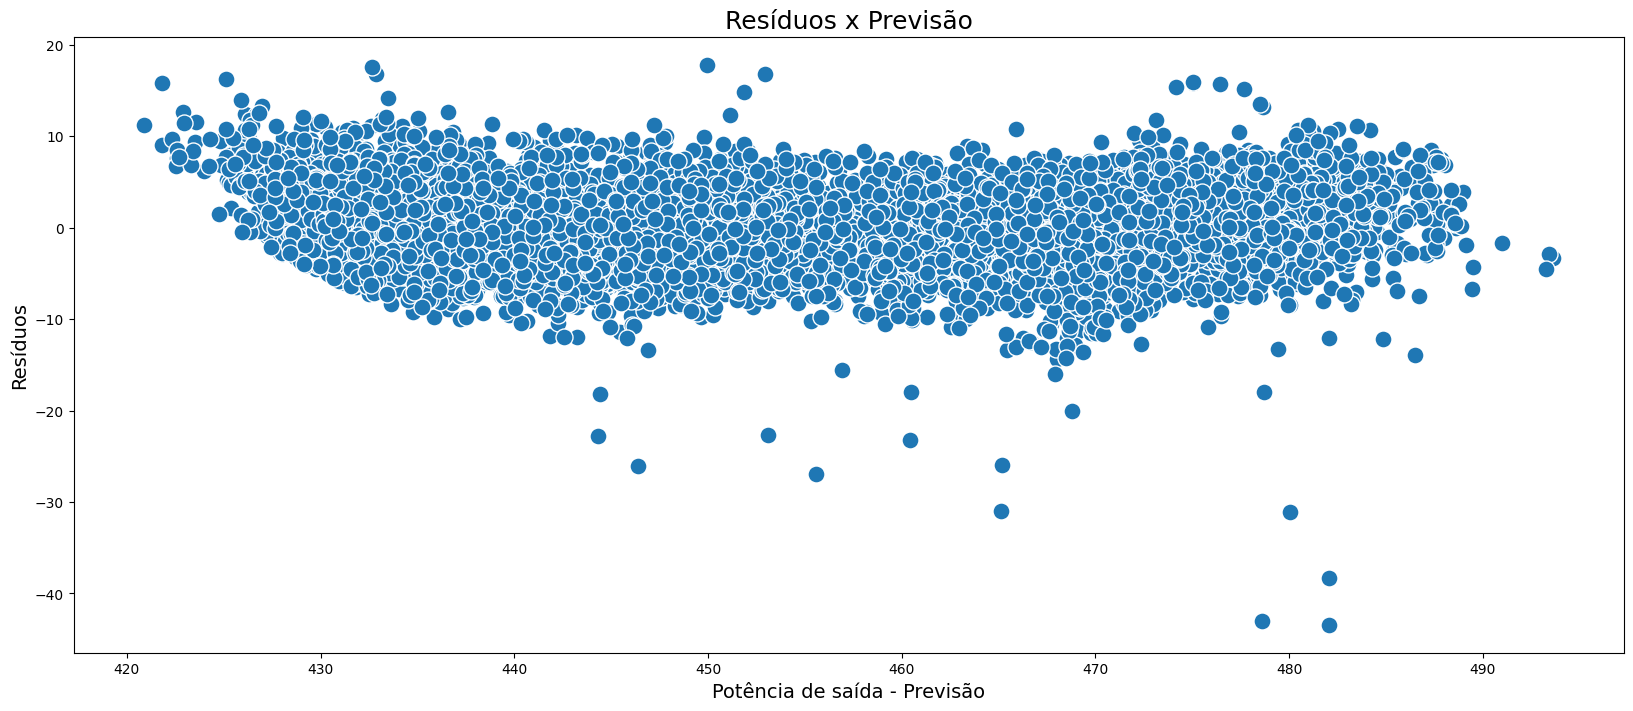

In [30]:
ax = sns.scatterplot(x = y_previsto_train, y = residuos, s=150)
ax.figure.set_size_inches(20, 8)
ax.set_title('Resíduos x Previsão', fontsize=18)
ax.set_xlabel('Potência de saída - Previsão', fontsize=14)
ax.set_ylabel('Resíduos', fontsize=14)
ax